<a href="https://colab.research.google.com/github/hiransuresh/ml-assignments/blob/main/6_6_Exercises_Hiran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.6 Exercises — Logistic Regression / Binary & Multiclass problems
Student: Hiran  
Notebook: `6.6_Exercises_Hiran.ipynb`

Instructions:
- For each question: Theory + Algorithm (text), Code (runnable), Output (run the cell), and Inference (text).
- Run all cells before saving/uploading.
## Question 1
**Problem:** A researcher is interested in how variables such as GRE, GPA and prestige (undergraduate institution) affect admission into graduate school. The response (admit / don't admit) is binary. Use dataset: https://stats.idre.ucla.edu/stat/stata/dae/binary.dta

### Theory
Logistic regression models the probability of a binary outcome (admit = 1 / not admit = 0) using the logistic (sigmoid) function. We estimate coefficients that show how each predictor (GRE, GPA, prestige) changes log-odds of admission.

### Algorithm (steps)
1. Load dataset (read .dta).  
2. Inspect columns and sample rows.  
3. Prepare predictors and binary target (encode categorical `prestige` if present).  
4. Split into train/test.  
5. Fit `LogisticRegression` (sklearn).  
6. Evaluate (accuracy, confusion matrix, ROC AUC).  
7. Interpret coefficients (odds ratios = exp(coef)).  

### Pseudocode


Columns: ['admit', 'gre', 'gpa', 'rank']


,admit,gre,gpa,rank
0,0.0,380.0,3.61,3.0
1,1.0,660.0,3.67,3.0
2,1.0,800.0,4.00,1.0
3,1.0,640.0,3.19,4.0
4,0.0,520.0,2.93,4.0


Accuracy: 0.7
Confusion matrix:
 [[77  5]
 [31  7]]
ROC AUC: 0.6763478818998716


,feature,coef,odds_ratio
2,prestige_1.0,0.687740,1.989214
1,gpa,0.660629,1.936010
3,prestige_2.0,0.300772,1.350902
0,gre,0.002719,1.002722
4,prestige_3.0,-0.432676,0.648770
5,prestige_4.0,-0.555821,0.573601


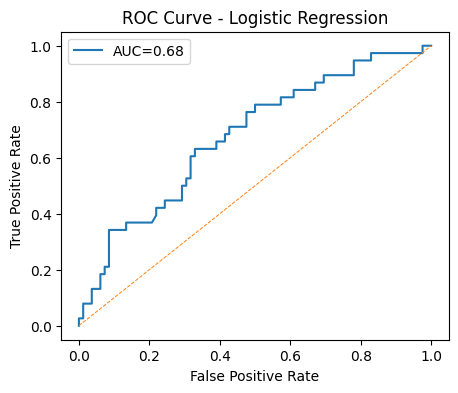

In [ ]:
# Q1 code: logistic regression on UCLA binary.dta
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Load dataset (from URL)
url = "https://stats.idre.ucla.edu/stat/stata/dae/binary.dta"
df = pd.read_stata(url)

# 2. Inspect
print("Columns:", df.columns.tolist())
display(df.head())

# NOTE: column names may be 'admit','gre','gpa','rank' or similar. Inspect and adjust:
# For this dataset, we expect a binary 'admit' and predictors gre, gpa, prestige/rank.
# If column named 'rank', treat as categorical 'prestige'

# 3. Prepare X, y
# Replace 'rank' below with the actual prestige column name if different.
target_col = 'admit'
if 'rank' in df.columns:
    prestige_col = 'rank'
elif 'prestige' in df.columns:
    prestige_col = 'prestige'
else:
    prestige_col = None

predictors = []
for c in ['gre','gpa']:
    if c in df.columns:
        predictors.append(c)

# If prestige/rank exists, one-hot encode it
if prestige_col:
    X = df[predictors].copy()
    dummies = pd.get_dummies(df[prestige_col].astype(str), prefix='prestige')
    X = pd.concat([X, dummies], axis=1)
else:
    X = df[predictors].copy()

y = df[target_col].astype(int)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# 5. Fit Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
try:
    auc = roc_auc_score(y_test, y_prob)
    print("ROC AUC:", auc)
except:
    pass

# 7. Coefficients -> odds ratios
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': model.coef_.flatten()
}).sort_values(by='coef', ascending=False)
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
display(coef_df)

# ROC curve plot (if applicable)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test,y_prob):.2f}")
plt.plot([0,1],[0,1],'--', linewidth=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### Inference (Q1)
- Check which features (GRE, GPA, prestige/rank dummies) have positive coefficients → increase admission probability.
- Odds ratios (exp(coef)) tell the multiplicative change in odds per unit increase of a predictor.
- Report accuracy, confusion matrix, and ROC AUC; discuss whether model performs well and possible improvements (regularization, more features, interaction terms).


## Question 2
**Problem:** For the given dataset (medical logistic regression example on datatab.net), investigate whether a person is susceptible to a certain disease or not.

### Theory
Logistic regression predicts disease risk (binary). Preprocessing (scaling, encoding) and evaluation (precision/recall) matter, especially if classes are imbalanced.

### Algorithm
1. Load the provided dataset or create synthetic dataset if not provided.
2. Explore data, handle missing values.
3. Choose features (e.g., age, blood_pressure, cholesterol, smoker).
4. Encode categorical features, scale numeric features.
5. Train logistic regression (or use class_weight if imbalance).
6. Evaluate (accuracy, precision, recall, F1, ROC AUC).


In [ ]:
# Q2 code: medical disease susceptibility (synthetic example)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Synthetic dataset: columns age, bp, cholesterol, smoker(0/1)
np.random.seed(0)
n = 400
age = np.random.randint(20, 80, size=n)
bp = np.random.normal(120, 15, size=n) + 0.2*(age-50)
chol = np.random.normal(200, 30, size=n) + 0.1*(age-50)
smoker = np.random.binomial(1, 0.25, size=n)

# Create probability of disease (synthetic logistic model)
logit = -6 + 0.05*age + 0.02*(bp) + 0.01*(chol) + 1.2*smoker
prob = 1 / (1 + np.exp(-logit))
y = (np.random.rand(n) < prob).astype(int)

df = pd.DataFrame({'age':age, 'bp':bp, 'chol':chol, 'smoker':smoker, 'disease':y})
display(df.head())

# Prepare data
X = df[['age','bp','chol','smoker']]
y = df['disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['age','bp','chol']])
X_test_scaled = scaler.transform(X_test[['age','bp','chol']])
# combine with smoker column (no scaling needed)
import numpy as np
X_train_ready = np.hstack([X_train_scaled, X_train[['smoker']].values])
X_test_ready = np.hstack([X_test_scaled, X_test[['smoker']].values])

# Train logistic regression (handle class imbalance if needed)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_ready, y_train)

# Evaluate
y_pred = model.predict(X_test_ready)
y_prob = model.predict_proba(X_test_ready)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Example: predict for a new person
new_person = pd.DataFrame({'age':[55],'bp':[140],'chol':[220],'smoker':[1]})
new_scaled = scaler.transform(new_person[['age','bp','chol']])
input_vec = np.hstack([new_scaled, new_person[['smoker']].values])
pred_prob = model.predict_proba(input_vec)[0,1]
print(f"Predicted disease probability for new person: {pred_prob:.2f}")


,age,bp,chol,smoker,disease
0,64,117.142645,188.183221,0,0
1,67,115.820534,171.735240,0,1
2,73,104.159933,170.843158,0,1
3,20,130.996905,214.156734,1,1
4,23,104.089654,201.808073,0,0


              precision    recall  f1-score   support

           0       0.68      0.36      0.47        36
           1       0.77      0.93      0.84        84

    accuracy                           0.76       120
   macro avg       0.73      0.64      0.66       120
weighted avg       0.75      0.76      0.73       120

ROC AUC: 0.7529761904761905
Predicted disease probability for new person: 0.93


### Inference (Q2)
- Report precision/recall/F1 and AUC.
- If recall (sensitivity) is more important (catch sick people), tune threshold or use class_weight to favor positive class.
- Suggest real-data considerations: cross-validation, feature selection, calibration.


## Question 3
**Problem:** For an online retailer, predict which product a particular customer is most likely to buy using a dataset (multi-class classification). Use logistic regression (multinomial) or another classifier.

### Theory
This is a multi-class classification problem. Multinomial logistic regression (softmax) can predict probabilities of multiple classes. We will create synthetic features like age, income, past_purchases, browsing_time and predict product category.

### Algorithm
1. Load dataset (or generate synthetic).  
2. Explore and preprocess features (scale/encode).  
3. Train `LogisticRegression(multi_class='multinomial', solver='lbfgs')` or `RandomForestClassifier`.  
4. Evaluate using accuracy and per-class precision/recall.


,age,income,past_purchases,browsing_time,product
0,55,32610.510707,2,14.479805,1
1,61,41874.700023,2,18.176231,1
2,30,47271.224990,2,4.068873,2
3,26,39162.581166,3,1.037129,2
4,27,51804.450554,0,2.051548,2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9611111111111111
              precision    recall  f1-score   support

           1       0.96      0.90      0.93        50
           2       0.96      0.98      0.97       130

    accuracy                           0.96       180
   macro avg       0.96      0.94      0.95       180
weighted avg       0.96      0.96      0.96       180



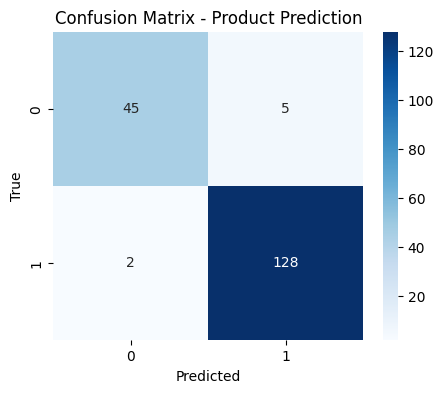

In [ ]:
# Q3 code: product prediction (multiclass logistic regression on synthetic data)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Synthetic dataset
np.random.seed(1)
n = 600
age = np.random.randint(18, 70, size=n)
income = np.random.normal(40000, 15000, size=n)
past_purchases = np.random.poisson(2, size=n)
browsing_time = np.random.exponential(10, size=n)  # minutes

# create 3 product categories
# simple rules to create labels so model can learn
prob_A = 1/(1+np.exp(-( -3 + 0.02*(age-30) + 0.00005*(income-40000) + 0.3*past_purchases )))
prob_B = 1/(1+np.exp(-( -1 + 0.01*(age-30) - 0.00003*(income-40000) + 0.1*browsing_time )))
prob_C = 1 - (prob_A+prob_B)/2  # just to vary
# make choose class by argmax after adding noise
scores = np.vstack([prob_A + np.random.rand(n)*0.1, prob_B + np.random.rand(n)*0.1, prob_C + np.random.rand(n)*0.1]).T
y = np.argmax(scores, axis=1)  # 0,1,2

df = pd.DataFrame({'age':age, 'income':income, 'past_purchases':past_purchases, 'browsing_time':browsing_time, 'product':y})
display(df.head())

# Prepare
X = df[['age','income','past_purchases','browsing_time']]
y = df['product']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Accuracy:", model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Show confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Product Prediction")
plt.show()


### Inference (Q3)
- Check per-class precision/recall to see which product classes are harder to predict.
- If performance is low, consider more features (demographics, browsing history), class balancing, or tree-based models.
